# Section 3 Project : Liked/Dislike Classification



In [ ]:
! pip install chart_studio

In [ ]:
! pip install -U pandas-profiling

In [ ]:
! pip install category_encoders
! pip install --upgrade git+https://github.com/scikit-learn-contrib/category_encoders

In [ ]:
! pip install eli5

In [ ]:
!pip install pdpbox
!pip install shap

In [ ]:
# 경고문 무시하기
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# importing library

import numpy as np # linear algebra
from scipy import stats # statistic library
import pandas as pd # To table manipulations
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# # Standard plotly imports
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# import plotly.tools as tls
# from plotly.offline import iplot, init_notebook_mode

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
# from category_encoders import OneHotEncoder, OrdinalEncoder

#Models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Data Preprocessing

In [ ]:
import pandas as pd

raw_csv = 'data.csv'
df = pd.read_csv(raw_csv)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


In [ ]:
df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
liked                 int64
dtype: object

In [ ]:
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
liked               0
dtype: int64

In [ ]:
## 타겟, 특성 나누기
target = 'liked'
features = df.columns.tolist()
features.remove(target)
# binary
bi_features = 'mode'
# numeric
num_features = list(set(features).difference([bi_features]))

target, bi_features, num_features

('liked',
 'mode',
 ['speechiness',
  'acousticness',
  'energy',
  'time_signature',
  'valence',
  'tempo',
  'key',
  'duration_ms',
  'danceability',
  'liveness',
  'loudness',
  'instrumentalness'])

# EDA

## 1. Pandas Profiling

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. target class 분포 파악 (by `churn`)


In [ ]:
df[target].value_counts(normalize=True)

1    0.512821
0    0.487179
Name: liked, dtype: float64

In [ ]:
df[target]

0      0
1      1
2      0
3      1
4      1
      ..
190    0
191    0
192    0
193    1
194    1
Name: liked, Length: 195, dtype: int64

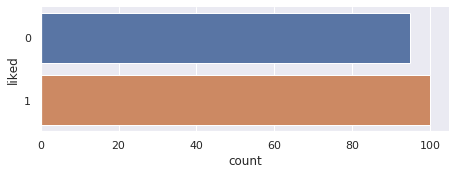

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()
sns.catplot(y=target, data = df, kind='count', height=2.6, aspect=2.5, orient='h');

## 3. numeric features 분포 파악

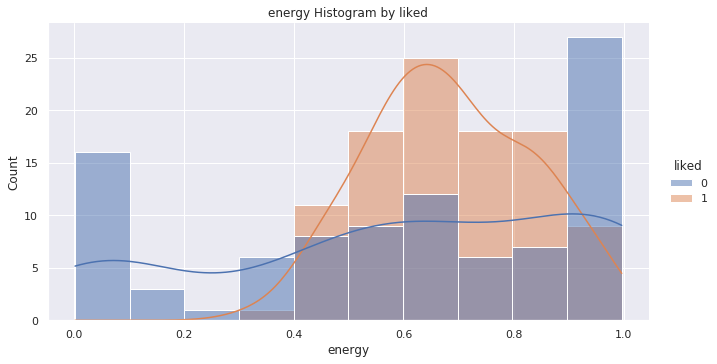

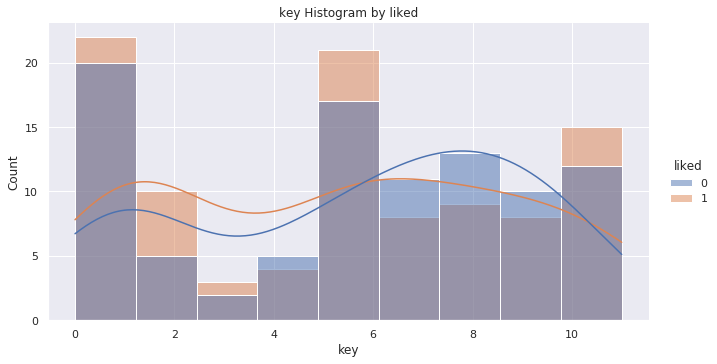

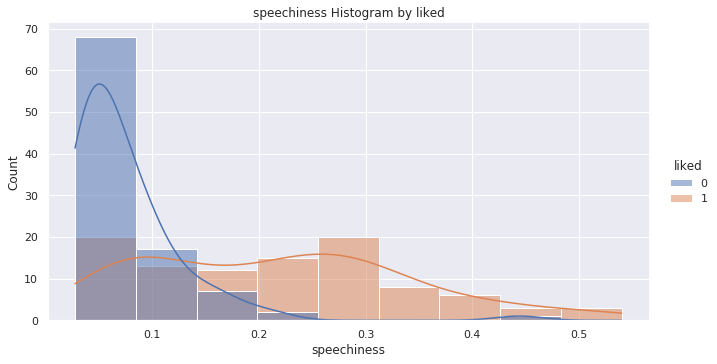

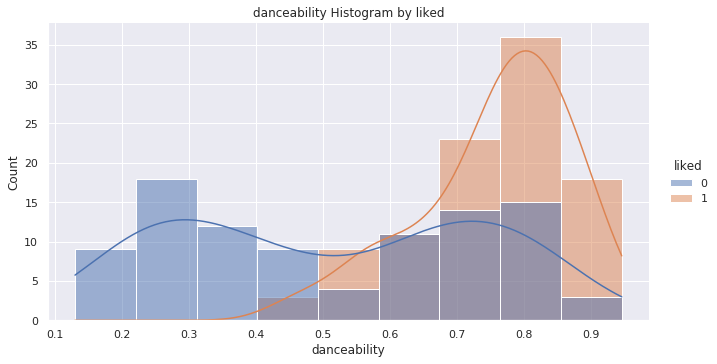

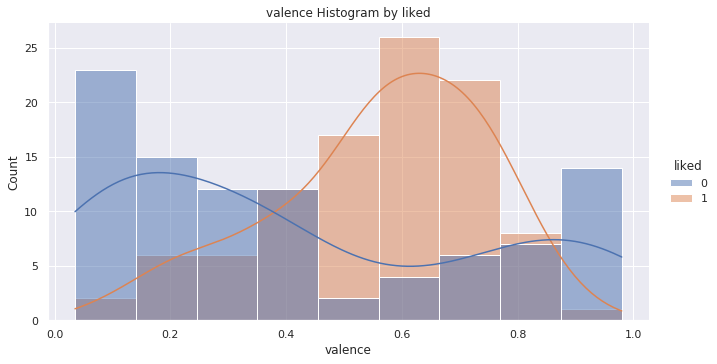

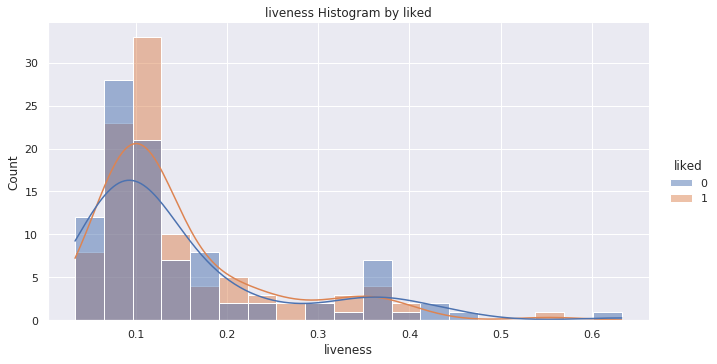

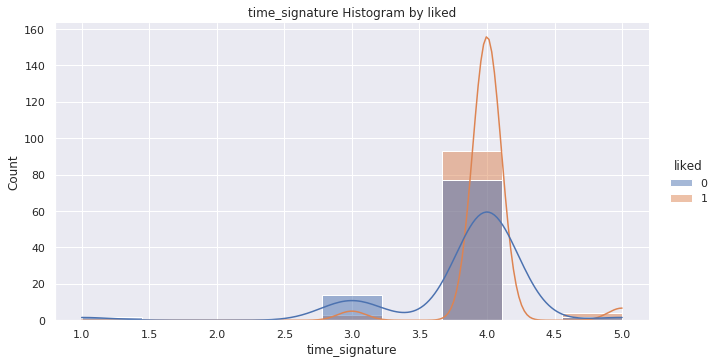

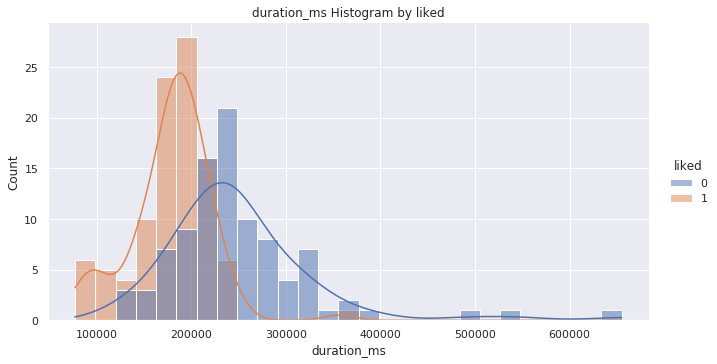

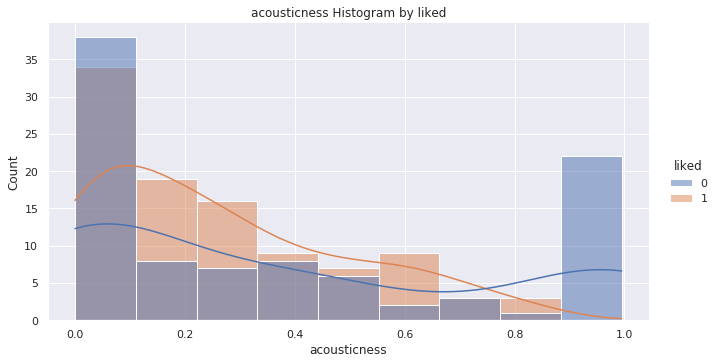

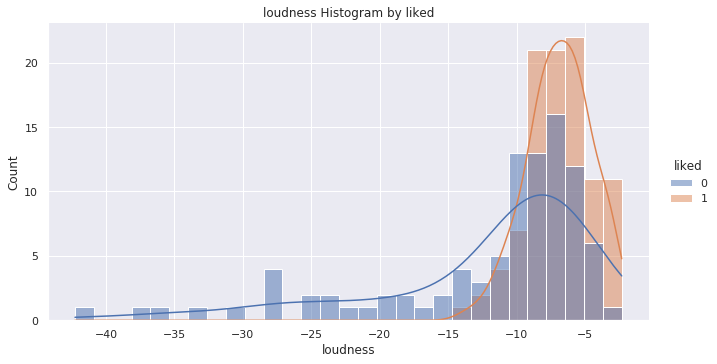

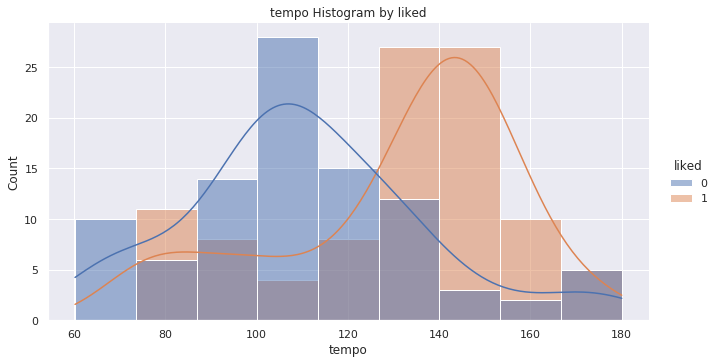

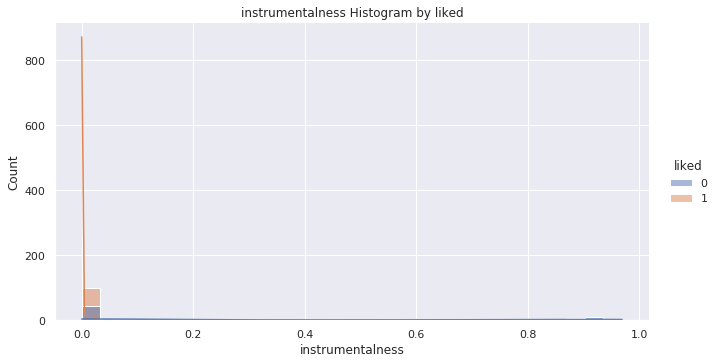

In [ ]:
sns.set_theme()
for s in num_features:
    ax = sns.displot(df, x=s, hue=target, kde=True, aspect=15/8);
    plt.title('{} Histogram by {}'.format(s, target))

## 4. categorical features 분포 파악

In [ ]:
def Churn_by_feature_countplot(df, col):
    chrun_to_feature = df.groupby(['Churn', col]).count()
    chrun_to_feature = chrun_to_feature.mean(axis=1).reset_index().rename(columns={0:'Counts'}).pivot_table(index=col, columns='Churn', values='Counts')
    chrun_to_feature['Ratio(%)'] = (chrun_to_feature[1] / (chrun_to_feature[0]+chrun_to_feature[1]))*100

    sns.set_theme()
    plt.figure(figsize=(10,6))
    ax = sns.countplot(data=df, x=col, hue="Churn")

    plt.title('Churn count by {}'.format(col))
    return chrun_to_feature

In [ ]:
groupby = df.groupby([target, 'mode']).count()
count_by_liked = count.mean(axis=1).reset_index().rename(columns={0:'Counts'}).pivot_table(index='mode', columns=target, values='Counts')
count_by_liked['Ratio(%)'] = (count_by_liked[1] / (count_by_liked[0]+count_by_liked[1]))*100

count_by_liked

liked,0,1,Ratio(%)
mode,,,
0,45.0,45.0,50.000000
1,50.0,55.0,52.380952


Text(0.5, 1.0, 'Churn count by mode')

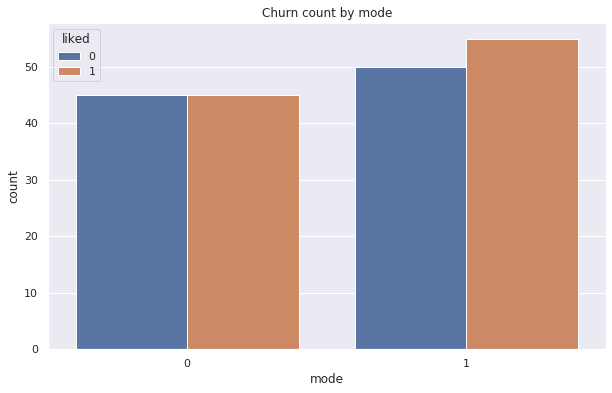

In [ ]:
sns.set_theme()
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='mode', hue=target)

plt.title('Churn count by mode')

## 5. 상관관계 파악

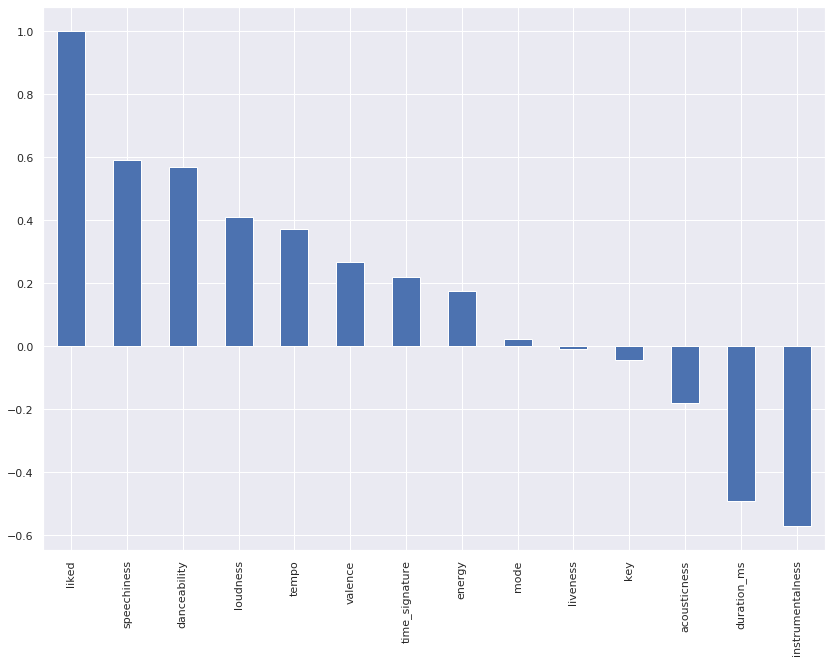

In [ ]:
# target과 feature들의 상관관계 파악하기
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
(pd.get_dummies(df).corr()[target]).sort_values(ascending=False).plot(kind='bar');

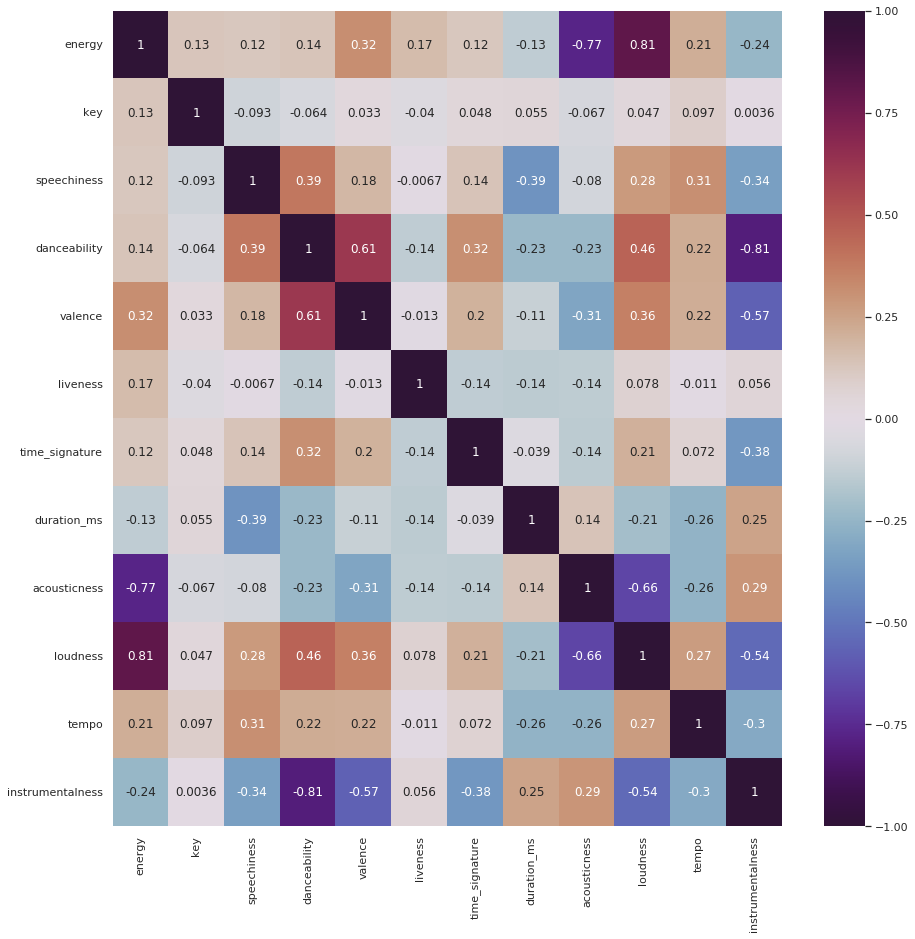

In [ ]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(df[num_features].corr(), cmap='twilight_shifted', vmin=-1, vmax=1, annot=True)
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5); # 아래 위 잘림 방지


0. 85가 넘어가는 feature가 없으므로 빼지 않는다.

---


# Machine Learning Modeling

In [ ]:
# ## 타겟, 특성 나누기
# target = 'liked'
# features = df.columns.tolist()
# features.remove(target)
# # binary
# bi_features = ['mode']
# # numeric
# num_features = list(set(features).difference(bi_features))

target, bi_features, num_features

('liked',
 'mode',
 ['time_signature',
  'speechiness',
  'acousticness',
  'danceability',
  'loudness',
  'tempo',
  'instrumentalness',
  'duration_ms',
  'key',
  'energy',
  'liveness',
  'valence'])

In [ ]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=10)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [ ]:
scale_pos_weight = train[target].value_counts()[0] / train[target].value_counts()[1]

In [ ]:
type(train[target].value_counts())

pandas.core.series.Series

In [ ]:
test['liked'].sum()

20

In [ ]:
from sklearn.metrics import classification_report

def testset_ClassificationReport(model, X_test):
    y_pred_test = model.predict(X_test)
    return print(classification_report(y_test, y_pred_test))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def testset_roc_auc_score(model, X_test):
    y_pred_proba = model.predict_proba(X_test)[:, -1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.scatter(fpr, tpr, color='blue')
    plt.plot(fpr, tpr, color='green')
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    return print('AUC score: ', roc_auc_score(y_test, y_pred_proba))

## 0. Baseline Model

In [ ]:
train[target].value_counts(normalize=True)

1    0.512821
0    0.487179
Name: liked, dtype: float64

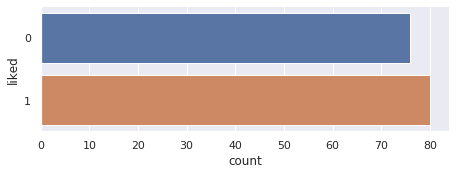

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()
sns.catplot(y=target, data = train, kind='count', height=2.6, aspect=2.5, orient='h');

- **기준 모델은 최빈 클래스인 1, 성능(Accuracy)은 최빈 클래스의 비율인 0.51이다.**

## 1. Random Forest

1. 기본 모델링

In [ ]:

clf_rf = make_pipeline(
    RandomForestClassifier(n_jobs=-1, random_state=10)
)

clf_rf.fit(X_train, y_train);

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(estimator = clf_rf , X = X_train, y = y_train, cv = 5)
print("Cross validation accuracy of RF model = ", cross_validation)
print("\nCross validation mean accuracy of RF model = ", cross_validation.mean())

Cross validation accuracy of RF model =  [0.875      0.93548387 0.90322581 0.90322581 0.93548387]

Cross validation mean accuracy of RF model =  0.910483870967742


In [ ]:
# 검증 데이터셋에서의 성능
testset_ClassificationReport(clf_rf, X_test)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.95      0.95        20

    accuracy                           0.95        39
   macro avg       0.95      0.95      0.95        39
weighted avg       0.95      0.95      0.95        39



AUC score:  0.986842105263158


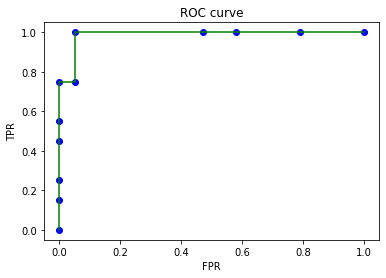

In [ ]:
testset_roc_auc_score(clf_rf, X_test)

In [ ]:
param_tuning = {
'randomforestclassifier__class_weight' : ['balanced',scale_pos_weight],
'randomforestclassifier__n_estimators': [10, 50, 100],
'randomforestclassifier__max_depth': [1, 5, 10],
'randomforestclassifier__min_samples_leaf' : [5, 10, 15],
'randomforestclassifier__min_samples_split' : [3, 7, 15],
'randomforestclassifier__max_features': [0.3, 0.5, 0.7] # max_features
}

from sklearn.model_selection import GridSearchCV

clf_rf_rmd = GridSearchCV(estimator = clf_rf,
                        param_grid = param_tuning,                        
                        scoring = 'accuracy',
                        cv = 3,
                        n_jobs = -1,
                        verbose = 1)

## 리모델링                        
clf_rf_rmd.fit(X_train, y_train);

## 결과
y_pred = clf_rf_rmd.predict(X_test)
y_pred_proba = clf_rf_rmd.predict_proba(X_test)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1451 out of 1458 | elapsed:   56.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed:   56.3s finished


In [ ]:
y_pred_proba

array([[0.88443695, 0.11556305],
       [0.24072634, 0.75927366],
       [0.01337643, 0.98662357],
       [0.7074513 , 0.2925487 ],
       [0.37888325, 0.62111675],
       [0.10882587, 0.89117413],
       [0.10996181, 0.89003819],
       [0.67029479, 0.32970521],
       [0.01216809, 0.98783191],
       [0.9785302 , 0.0214698 ],
       [0.22070385, 0.77929615],
       [0.87316651, 0.12683349],
       [0.89773209, 0.10226791],
       [0.81201392, 0.18798608],
       [0.22928483, 0.77071517],
       [0.45472226, 0.54527774],
       [0.90690558, 0.09309442],
       [0.46322897, 0.53677103],
       [0.82192043, 0.17807957],
       [0.12329879, 0.87670121],
       [0.58627508, 0.41372492],
       [0.14241052, 0.85758948],
       [0.05168197, 0.94831803],
       [0.05422629, 0.94577371],
       [0.89007086, 0.10992914],
       [0.84918259, 0.15081741],
       [0.00628578, 0.99371422],
       [0.30711614, 0.69288386],
       [0.11069146, 0.88930854],
       [0.97864002, 0.02135998],
       [0.

## 2. xgboost Model

1. 기본 모델링

In [ ]:
pipe_xgb = make_pipeline(
    XGBClassifier(random_state=10)
)

pipe_xgb.fit(X_train, y_train);

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(estimator =pipe_xgb , X = X_train, y = y_train, cv = 5)
print("Cross validation accuracy of XGBoost model = ", cross_validation)
print("\nCross validation mean accuracy of XGBoost model = ", cross_validation.mean())

Cross validation accuracy of XGBoost model =  [0.90625    0.93548387 0.96774194 0.87096774 0.96774194]

Cross validation mean accuracy of XGBoost model =  0.9296370967741936


In [ ]:
# 테스트셋에서의 성능 확인
testset_ClassificationReport(pipe_xgb, X_test)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.90      0.90      0.90        20

    accuracy                           0.90        39
   macro avg       0.90      0.90      0.90        39
weighted avg       0.90      0.90      0.90        39



AUC score:  0.9842105263157894


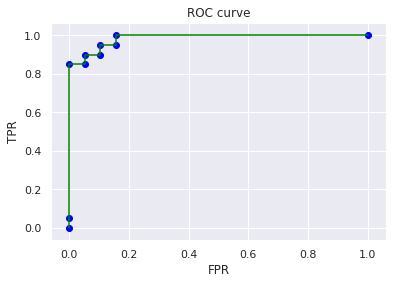

In [ ]:
testset_roc_auc_score(pipe_xgb, X_test)

In [ ]:
# 성능 개선 확인
valset_ClassificationReport(pipe_xgb_rmd, X_val)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       849
           1       0.59      0.54      0.56       278

    accuracy                           0.79      1127
   macro avg       0.72      0.71      0.71      1127
weighted avg       0.79      0.79      0.79      1127



## 3. Logistic Regression Model

In [ ]:
num_features

['mode',
 'energy',
 'key',
 'speechiness',
 'danceability',
 'valence',
 'liveness',
 'time_signature',
 'duration_ms',
 'acousticness',
 'loudness',
 'tempo',
 'instrumentalness']

In [ ]:
def engineering_for_Logistic(df):
    df_new = df.copy()
    # 연속형 변수들의 로그 log transformation
    # np.log를 사용하면 -inf값 생김 -> log1p사용
    for s in num_features:
        df_new[s] = np.log1p(df_new[s])
    # 음수값이 있는 feature는 가장 작은 값을 더해서 양의 방향으로 평행이동 후 로그변환
    df_new['loudness'] = np.log1p(df['loudness']-min(df['loudness']))

    # 변수 제거(상관관계 참고)
    df_new = df_new.drop(['mode', 'liveness', 'key'], axis=1)

    return df_new

X_train_trsd = engineering_for_Logistic(X_train)
X_test_trsd = engineering_for_Logistic(X_test)

1. 기본 모델링

In [ ]:
pipe_lgr = make_pipeline(
    LogisticRegressionCV(random_state=10,
                       max_iter=1000)
)

pipe_lgr.fit(X_train_trsd, y_train);

In [ ]:
# Cross validation
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(estimator=pipe_lgr , X = X_train_trsd, y = y_train, cv = 5)
print("Cross validation accuracy of Logistic Regression model = ", cross_validation)
print("\nCross validation mean accuracy of Logistic Regression model = ", cross_validation.mean())

Cross validation accuracy of Logistic Regression model =  [0.84375    0.87096774 0.96774194 0.87096774 0.90322581]

Cross validation mean accuracy of Logistic Regression model =  0.8913306451612903


2. 모델 최적화

In [ ]:
# 하이퍼 파라미터 튜닝
pipe_lgr_rmd = make_pipeline(
    LogisticRegressionCV(random_state=10,
                         scoring = 'roc_auc',
                         max_iter=1000)
)

pipe_lgr_rmd.fit(X_train_trsd, y_train);

In [ ]:
# 성능 개선 확인
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(estimator=pipe_lgr_rmd , X = X_train_trsd, y = y_train, cv = 5)
print("Cross validation accuracy of Logistic Regression model = ", cross_validation)
print("\nCross validation mean accuracy of Logistic Regression model = ", cross_validation.mean())

Cross validation accuracy of Logistic Regression model =  [0.90234375 0.97083333 0.94583333 0.92916667 0.98333333]

Cross validation mean accuracy of Logistic Regression model =  0.9463020833333335


In [ ]:
# 테스트셋에서의 성능 확인
testset_ClassificationReport(pipe_lgr, X_test_trsd)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        19
           1       1.00      0.55      0.71        20

    accuracy                           0.77        39
   macro avg       0.84      0.78      0.76        39
weighted avg       0.84      0.77      0.76        39



AUC score:  0.9947368421052633


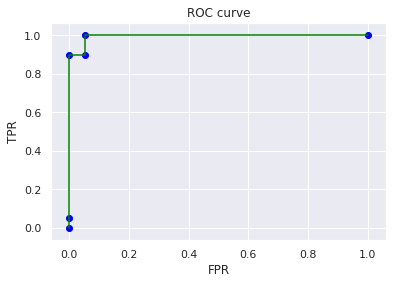

In [ ]:
testset_roc_auc_score(pipe_lgr, X_test_trsd)

- 하이퍼 파라미터 값을 조정해봐도 별 차이가 없으나, 조정한 모델이 아주 약간 더 좋다.

## 4. 모델 비교 및 성능 평가

- Random Forest

In [ ]:
testset_ClassificationReport(pipe_rf, X_test)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.95      0.95        20

    accuracy                           0.95        39
   macro avg       0.95      0.95      0.95        39
weighted avg       0.95      0.95      0.95        39



AUC score:  0.986842105263158


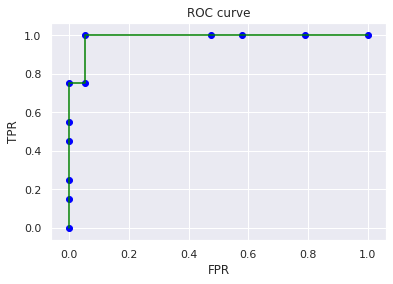

In [ ]:
testset_roc_auc_score(pipe_rf, X_test)

- xgboost

In [ ]:
testset_ClassificationReport(pipe_xgb, X_test)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.90      0.90      0.90        20

    accuracy                           0.90        39
   macro avg       0.90      0.90      0.90        39
weighted avg       0.90      0.90      0.90        39



AUC score:  0.9842105263157894


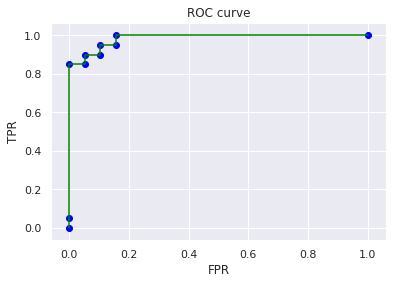

In [ ]:
testset_roc_auc_score(pipe_xgb, X_test)

- Logistic Regression

In [ ]:
testset_ClassificationReport(pipe_lgr, X_test_trsd)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        19
           1       1.00      0.55      0.71        20

    accuracy                           0.77        39
   macro avg       0.84      0.78      0.76        39
weighted avg       0.84      0.77      0.76        39



AUC score:  0.9947368421052633


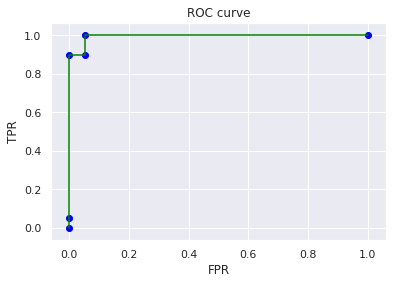

In [ ]:
testset_roc_auc_score(pipe_lgr_rmd, X_test_trsd)

> ***종합적으로 고려해 가장 안정적인 Random Forest 모델을 최종 모델로 선정한다.***


#### 이 모델의 한계

- 적은 표본 수

## Permutation Importance 확인 후 Feature Selection

- 필요한 feature들만 남겨서 다시 모델링한다.

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_rf.named_steps['randomforestclassifier'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=10
)


permuter.fit(X_test, y_test);

In [ ]:
# 특성별 score 확인
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0462 ± 0.0502,instrumentalness
0.0359 ± 0.0410,tempo
0.0359 ± 0.0410,duration_ms
0.0256 ± 0.0459,danceability
0.0154 ± 0.0615,speechiness
0.0154 ± 0.0523,loudness
0.0051 ± 0.0205,acousticness
0.0051 ± 0.0205,energy
0 ± 0.0000,time_signature
0 ± 0.0000,valence


- 중요도가 0인 특성은 제거해준다.

In [ ]:
print('특성 삭제 전:', X_train.shape, X_test.shape)

특성 삭제 전: (156, 13) (39, 13)


In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
selected_features = X_train.columns[mask]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
print('특성 삭제 후:', X_train_selected.shape, X_test_selected.shape)

특성 삭제 후: (156, 8) (39, 8)


In [ ]:
# 특성 삭제 후 리모델링
pipe_rf_rmd = make_pipeline(
    RandomForestClassifier(n_jobs=-1, random_state=10)
)

pipe_rf_rmd.fit(X_train_selected, y_train);

## 최종 모델의 성능

In [ ]:
testset_ClassificationReport(pipe_rf_rmd, X_test_selected)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.95      0.95        20

    accuracy                           0.95        39
   macro avg       0.95      0.95      0.95        39
weighted avg       0.95      0.95      0.95        39



AUC score:  0.9868421052631579


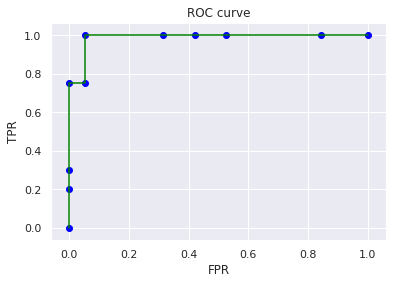

In [ ]:
testset_roc_auc_score(pipe_rf_rmd, X_test_selected)

# Interpreting ML Model

## 1. Permutation Importance 확인하기

In [ ]:
# permuter 정의
permuter2 = PermutationImportance(
    pipe_rf_rmd.named_steps['randomforestclassifier'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=10
)

permuter2.fit(X_test_selected, y_test);

In [ ]:
# 특성별 score 확인
feature_names2 = X_test_selected.columns.tolist()

eli5.show_weights(
    permuter2, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names2 # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0471 ± 0.0181,instrumentalness
0.0232 ± 0.0240,duration_ms
0.0187 ± 0.0179,tempo
0.0137 ± 0.0106,speechiness
0.0053 ± 0.0050,acousticness
0.0034 ± 0.0096,danceability
0.0016 ± 0.0136,loudness
0.0005 ± 0.0021,energy
